# Rice Kernel Image Classification 

This is the code of the following article  "Build Rice Kernel Image Classification model in PyTorch"

This classification can provide insights into the quality of rice, which is important for trading and pricing in the rice industry.

Please do not use this code for commercial purposes unless approved by the author. 


## Step 1: Set up the enivronment

In [35]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from sklearn.preprocessing import LabelEncoder

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available. Using CPU.")


Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## Step 2: Import the data

In [88]:
data_dir = r"C:\Users\User\Documents\New folder\Github\computervision-tools\classification\data_test"

# Initialize lists to store image data and corresponding class labels
images = []
labels = []

# Loop through subfolders (each subfolder represents a class)
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    # Check if the item in the directory is a folder (class subfolder)
    if os.path.isdir(class_dir):
        # Iterate through image files in the subfolder
        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            
            # Load the image using Pillow (PIL)
            image = Image.open(image_path)
            
            # Resize the image to a consistent size (e.g., 36x35 pixels)
            image = image.resize((36, 35))
            
            # Convert the image to a NumPy array
            image_array = np.array(image)
            
            # Append the image data and corresponding class label
            images.append(image_array)
            labels.append(class_name)


Shape of images array: (1632, 35, 36, 3)
(35, 36, 3)


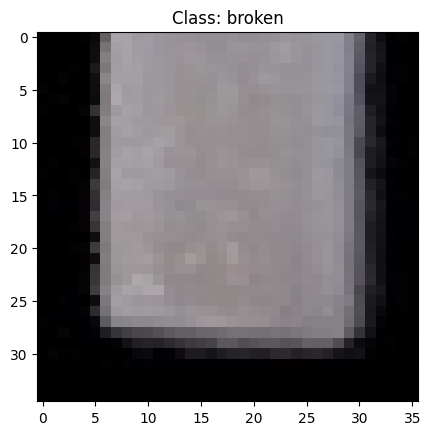

In [90]:
# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Check the shape of the loaded images array (num_images, height, width, num_channels)
print(f"Shape of images array: {images.shape}")

# Example: Display the first image from the loaded dataset
print(images[0].shape)
plt.imshow(images[0])
plt.title(f"Class: {labels[0]}")
plt.axis('on')
plt.show()

In [91]:
min_pixel_value = np.min(images)
max_pixel_value = np.max(images)

print(f"Minimum Pixel Value: {min_pixel_value}")
print(f"Maximum Pixel Value: {max_pixel_value}")

Minimum Pixel Value: 0
Maximum Pixel Value: 255


In [92]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)
# Transform the class labels into numerical labels
encoded_labels = label_encoder.transform(labels)

# Print the original class labels and their corresponding numerical labels
#for original_label, encoded_label in zip(labels, encoded_labels):
#    print(f"Original Label: {original_label}, Encoded Label: {encoded_label}")

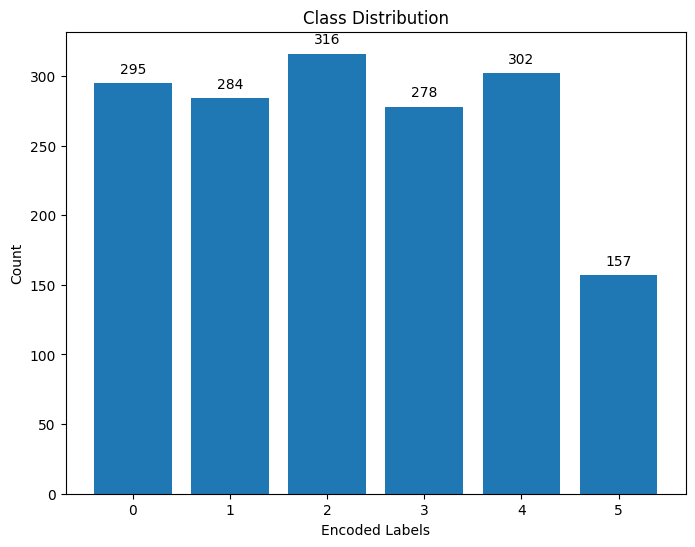

In [93]:
# Calculate the unique labels and their frequencies
unique_labels, label_counts = np.unique(encoded_labels, return_counts=True)

# Create a bar plot to visualize class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, label_counts, tick_label=unique_labels)

# Annotate the values on each bar
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Encoded Labels')
plt.ylabel('Count')
plt.title('Class Distribution')

# Show the plot
plt.show()


In [94]:
# Convert images and labels to PyTorch tensors
images_tr = torch.from_numpy(images).float()
labels = torch.from_numpy(encoded_labels)

In [95]:
#print(images_tr[0][0]) #Red Channel
#print(images_tr[0][1]) #Green Channel
#print(images_tr[0][2]) #Blue Channel

In [96]:
# Normalize the image data to the range [-1, 1]
#the original pixel values were in the range [0, 255]
images_normalized = (images_tr / 255.0) * 2.0 - 1.0

In [97]:
images_normalized.shape

torch.Size([1632, 35, 36, 3])

In [98]:
# Split the dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_normalized, labels, test_size=0.2, random_state=42)

In [99]:
# Create DataLoader objects for training and test sets
batch_size = 32  # You can adjust this based on your preference
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [100]:
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [101]:
# Check the number of samples in the training and test sets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 1305
Number of test samples: 327
